##  **I. Choose K**

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree # hierarchy clustering

In [201]:
# Data cleaned
cleaned_data = pd.read_csv('Dataset/cleaned_data.csv', encoding='latin-1')
# Data main
rfm = pd.read_csv('Dataset/rfm_data.csv', encoding='latin-1')
# Data đã scale
data_scaler = pd.read_csv('Dataset/scaled_data.csv', encoding='latin-1')
data_scaler.head()

,0,1,2
0,1.616184,-2.527118,-1.617948
1,-1.739111,1.140106,1.105301
2,0.298054,-0.257484,-0.394391
3,-0.704070,0.447572,0.267343
4,1.568625,-0.793078,-0.791230


#### **1. Using Elbow Method to choose K**

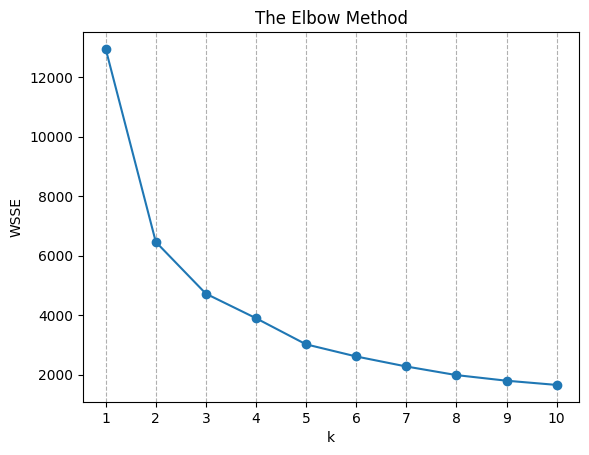

In [202]:
# Chọn số cụm bằng Elbow
from sklearn.cluster import KMeans

sse = {}
K_range = range(1, 11)
for k in K_range:
    # Tạo một bản KMeans với k cụm: model
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit the model to the data
    kmeans.fit(data_scaler)

    # tra ve gia tri SSE
    sse[k] = kmeans.inertia_ 

# set grid
plt.grid(axis = 'x', linestyle ='--')
plt.title('The Elbow Method')
plt.xticks(np.arange(0, 13, step=1))
plt.xlabel('k')
plt.ylabel('WSSE')
# Use plt.plot instead of plt.pointplot
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

- Chọn k sao cho khi k tăng thì tổng bình phương khoảng cách đến tâm cụm centroid là SSE không giảm đi nhiều
▶ Tại điểm K=3, mức giảm WSSE bắt đầu chậm lại, cho thấy việc tăng số lượng cụm sau K=3 không mang lại sự cải thiện đáng kể về mặt giảm WSSE. Điều này cho thấy rằng K=3 là số lượng cụm tối ưu, cân bằng giữa độ phức tạp của mô hình và độ chính xác của phân cụm.
- Nhưng chúng ta cần thử các phương pháp tính K khác

#### **2. Using Silhouette Method to choose K**

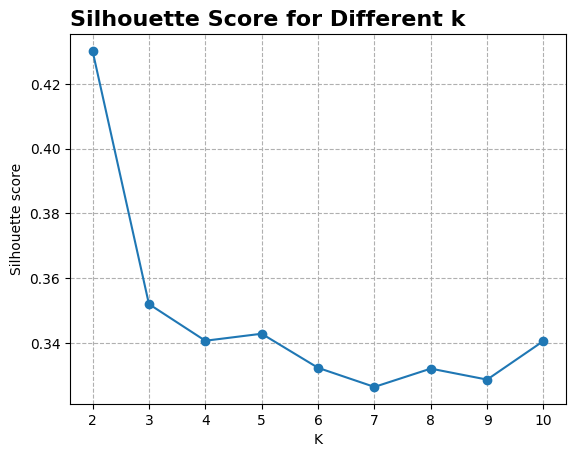

Best k value based on Silhouette Score: 2


In [203]:
# Tính điểm Silhouette trung bình cho các giá trị K khác nhau
silhouette_scores = []
possible_k_values = range(2, 11)  # k from 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(data_scaler)
    silhouette_scores.append(silhouette_score(data_scaler, labels))

# Vẽ đồ thị điểm Silhouette trung bình theo K

plt.title('Silhouette Score for Different k',loc = 'left',  fontweight = 'heavy', fontsize = 16)
plt.xlabel('Number of Clusters (k)')
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.grid(axis = 'x', linestyle ='--')
plt.grid(axis = 'y', linestyle ='--')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

# Điểm silhouette_scores cao nhất (best k)
best_k = possible_k_values[np.argmax(silhouette_scores)]
print(f"Best k value based on Silhouette Score: {best_k}")

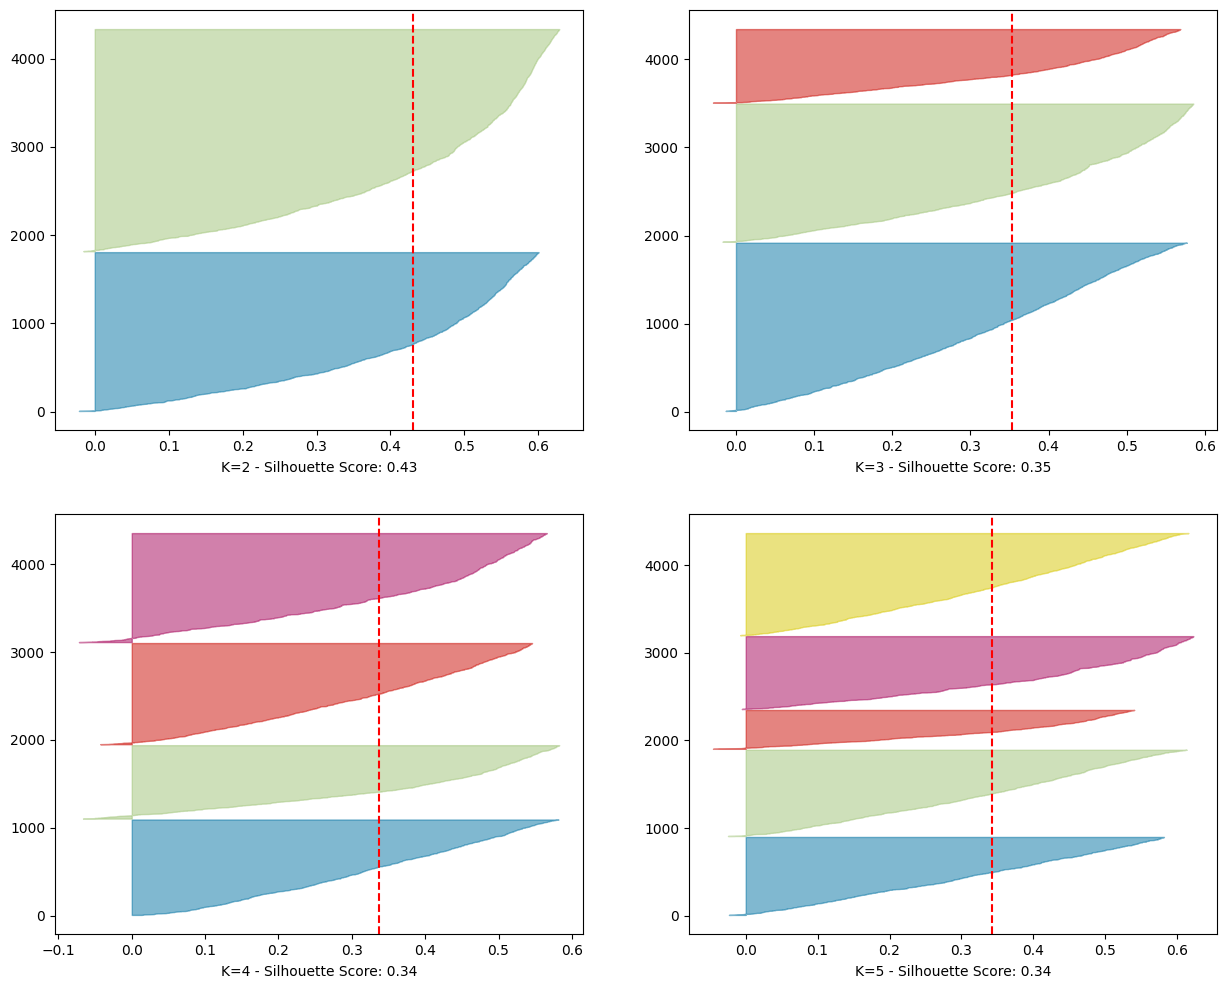

In [204]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,12))

for k in [2, 3, 4, 5]:
    # Khởi tạo thuật toán K-Means với k cụm
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaler)
    # Tính toán và in ra giá trị Silhouette trung bình
    silhouette_avg = np.mean(visualizer.silhouette_samples_)
    # Use q-1 instead of q to access the correct axes object
    ax[q-1][mod].text(0.5, -0.1, f'K={k} - Silhouette Score: {silhouette_avg:.2f}', ha='center', transform=ax[q-1][mod].transAxes)
# plt.title('Silhouette Method')
plt.xlabel('')
plt.ylabel('')
plt.show()

- Điểm Silhouette trung bình (Silhouette Score) cho K=2 đạt giá trị cao nhất (0.43), nhưng khi nhìn vào mật độ dữ liệu trong mỗi cụm tương đối cao. Tuy điểm số và sự tập trung dữ liệu giữa các cụm là hợp lý nhưng chúng ta cần nhiều hơn 2 nhóm khách hàng trong bài toán này để xác định rõ hơn đặc điểm chi tiết của từng nhóm, tạo điều kiện lập kế hoạch hiệu quả cho thời gian sắp tới.
- Ở K=3 điểm Silhouette trung bình cũng khá tốt (0.36), các hình Silhouette có dạng khá "đều đặn", ít điểm dữ liệu ở ranh giới giữa các cụm. Dù không đẹp bằng K=2, nhưng vẫn tốt hơn K=4 và K=5.

#### **3. Using Hierarchical Clustering**

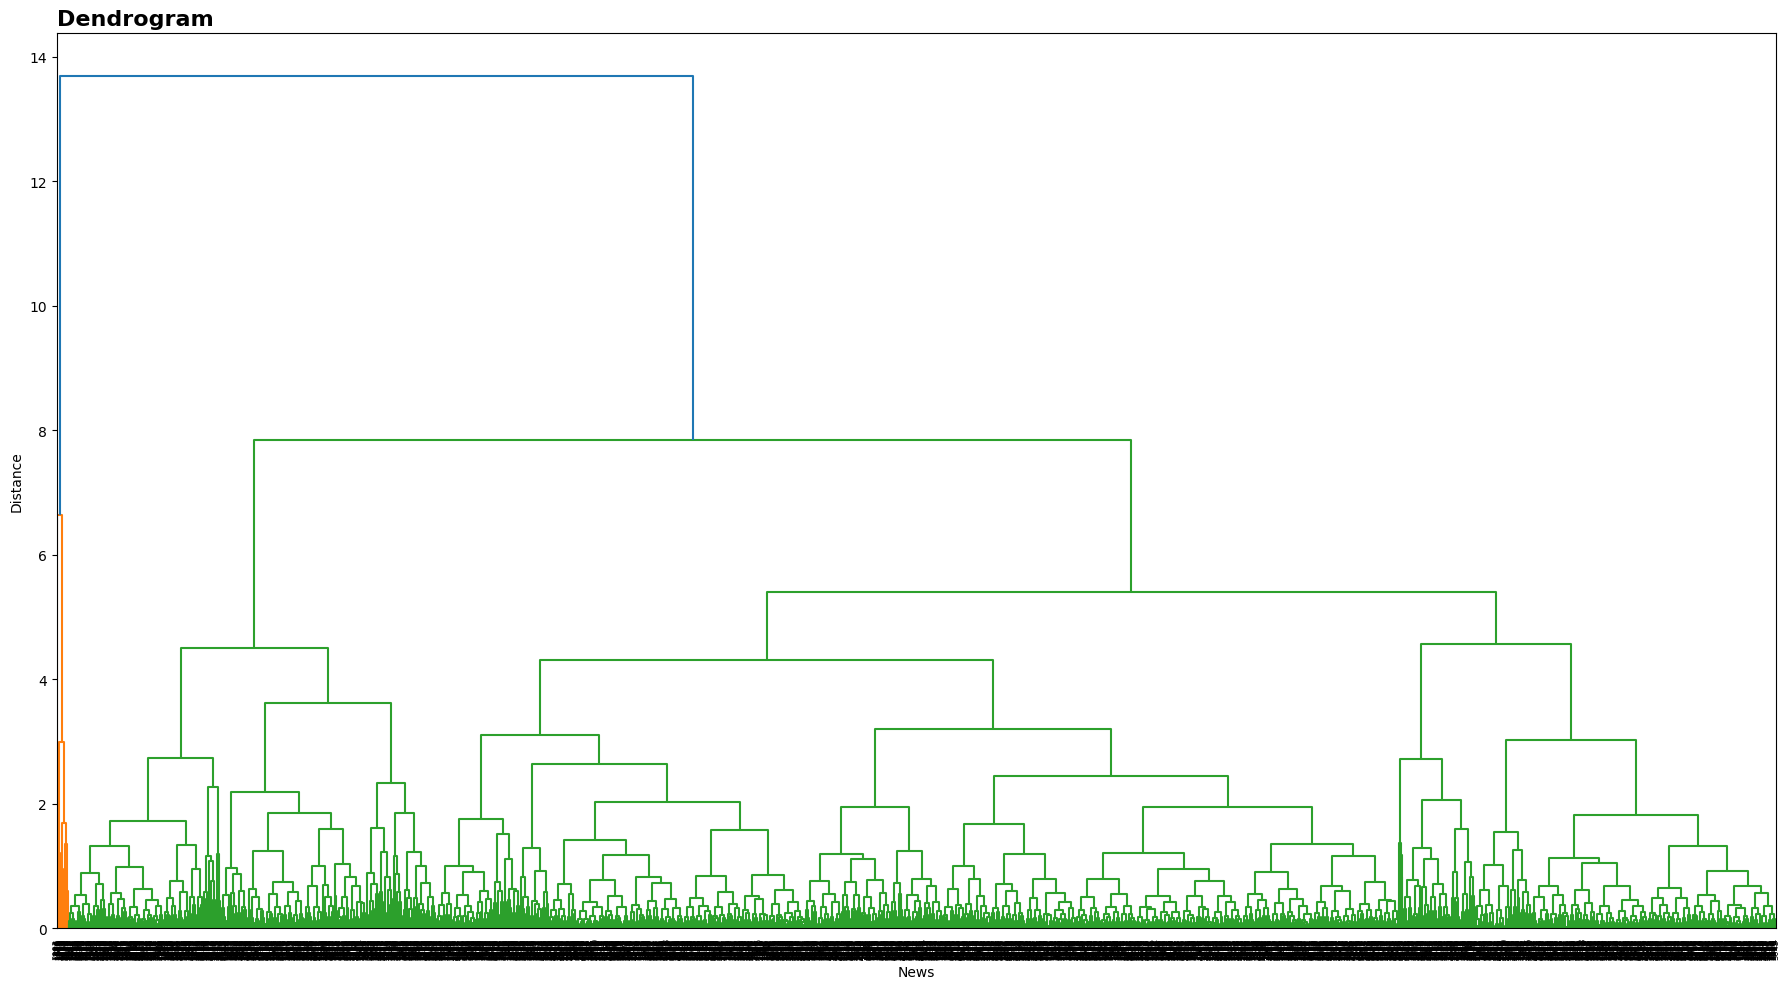

In [205]:
# Tính toán single linkage (khoảng cách giữa các cụm)
mergings = linkage(data_scaler, method="complete", metric='euclidean')
# Đặt lại kiểu biểu đồ
plt.style.use('default')
# Plot by dendogram
plt.figure(figsize=(18,10))
dendrogram(mergings, leaf_rotation= 90, leaf_font_size= 6)
plt.title('Dendrogram',loc = 'left',  fontweight = 'heavy', fontsize = 16)
plt.xlabel('News')
plt.ylabel('Distance')
plt.tight_layout()
plt.show();

`Comment:`  
Có thể thấy khoảng cách từ cột đầu (xanh dương) đến khoảng cách cột xanh lá và cam tương đối lớn (khoảng 6 và hơn) so với các điểm nối khác ▶ cho thấy cụm này tách biệt rõ ràng so với các cụm còn lại. ▶ Phân cụm tốt
▶ 3 cụm có vẻ là lựa chọn hợp lý nhất

`Kết luận:`
▶ Cả ba phương pháp đều chỉ ra K=3 là điểm tối ưu.
- Elbow Method chỉ ra K=3 là điểm tối ưu dựa trên việc giảm WSSSE.
- Silhouette Method cho thấy K=3 có khả năng mang lại sự phân cụm đều đặn hơn, mặc dù điểm Silhouette trung bình thấp hơn K=5.
-Hierarchical Clustering cũng chỉ ra K=3 là điểm cắt hợp lý nhất dựa trên khoảng cách giữa các cụm.

## **II. Choose k = 3 and fit it with scaler data**

In [206]:
# data = pd.DataFrame(data)  # Convert to DataFrame
# Convert all column names to strings
data_scaler.columns = data_scaler.columns.astype(str)
# Khởi tạo thuật toán K-Means với 3 cụm
model = KMeans(n_clusters=3, random_state = 42)
# Huấn luyện mô hình
model.fit(data_scaler)
# dự đoán cụm
clusters = model.predict(data_scaler)

In [207]:
# Phân bổ điểm dữ liệu vào các cụm
data_scaler['Cluster'] = model.labels_
data_scaler.head()

,0,1,2,Cluster
0,1.616184,-2.527118,-1.617948,1
1,-1.739111,1.140106,1.105301,0
2,0.298054,-0.257484,-0.394391,2
3,-0.704070,0.447572,0.267343,2
4,1.568625,-0.793078,-0.791230,1


In [208]:
# Tâm cụm
centroids = model.cluster_centers_
pd.DataFrame(centroids).head()

,0,1,2
0,-0.988279,1.385255,1.524867
1,0.872125,-0.931481,-0.830037
2,-0.288475,0.163511,0.018316


Text(0.5, 0.92, 'K-Means Clustering')

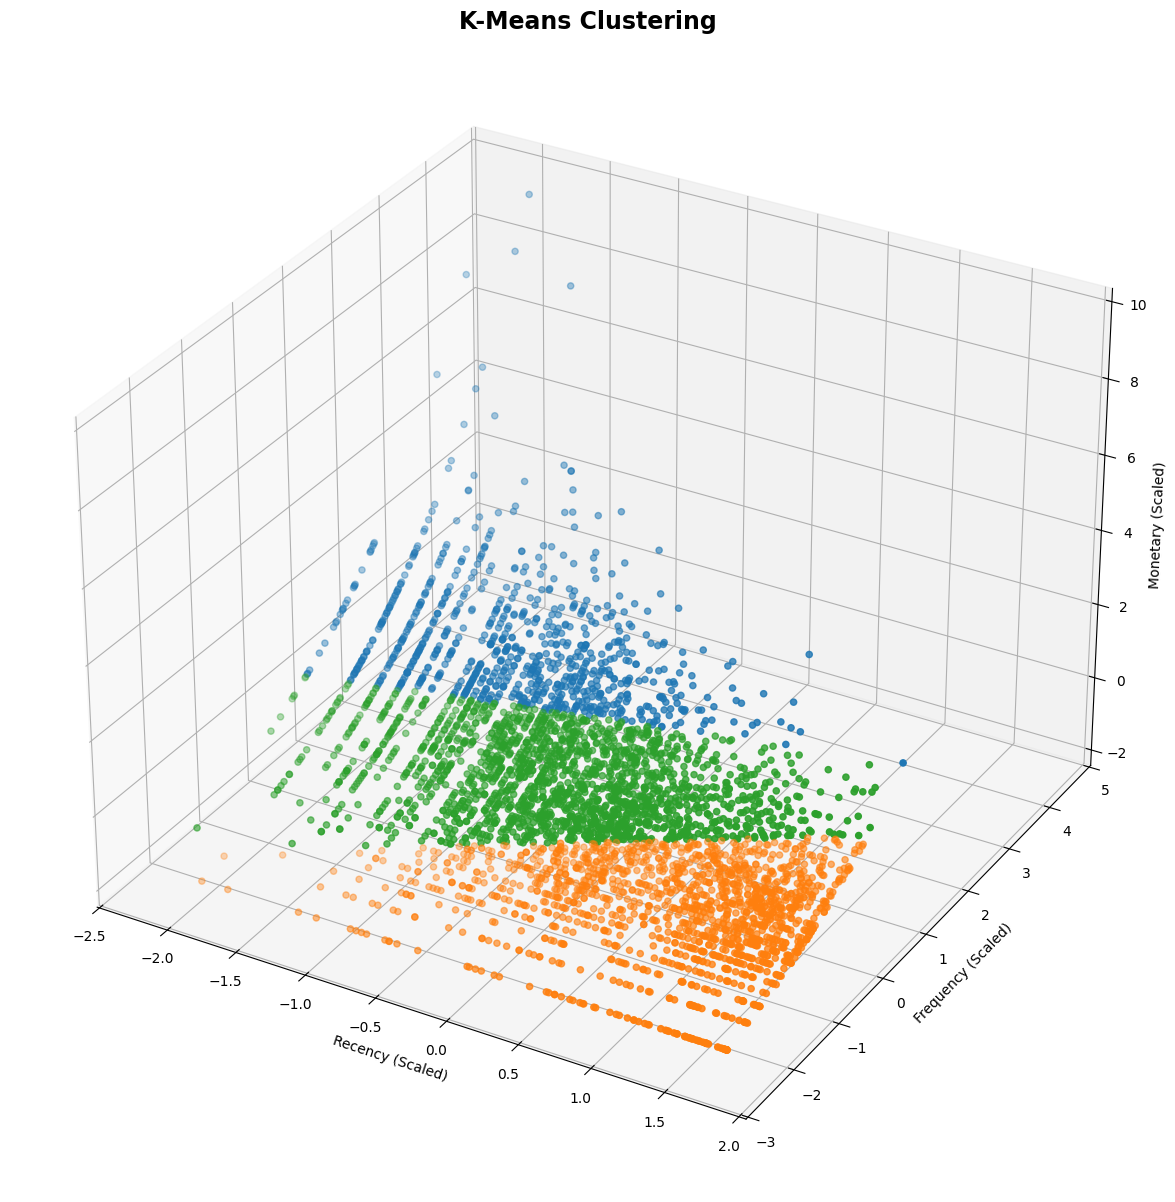

In [209]:
# Visualize with 3D graph by Recency, Frequency and Monetary
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Get the string names of the Recency, Frequency, and Monetary columns
recency_col = data_scaler.columns[0]  # Cột recency
frequency_col = data_scaler.columns[1]  # Cột frequency
monetary_col = data_scaler.columns[2]  # Cột Monetary

for i in range(k):
    cluster_data = data_scaler[data_scaler['Cluster'] == i]
    # Use the string column names to access the data
    ax.scatter(cluster_data[recency_col], cluster_data[frequency_col], cluster_data[monetary_col], label=f'Cluster {i}')

ax.set_xlabel('Recency (Scaled)')
ax.set_ylabel('Frequency (Scaled)')
ax.set_zlabel('Monetary (Scaled)')
ax.set_title('K-Means Clustering', fontsize=17, fontweight='bold')
# # Convert all column names to strings
# data.columns = data.columns.astype(str)

In [210]:
data_scaler

,0,1,2,Cluster
0,1.616184,-2.527118,-1.617948,1
1,-1.739111,1.140106,1.105301,0
2,0.298054,-0.257484,-0.394391,2
3,-0.704070,0.447572,0.267343,2
4,1.568625,-0.793078,-0.791230,1
...,...,...,...,...
4310,1.456787,-0.980682,-0.911690,1
4311,1.046791,-1.231862,-1.059436,1
4312,-1.226773,-0.850570,-0.829103,2
4313,-1.596983,2.400317,3.250990,0


In [211]:
# Check Cluster Centers
kmeans.cluster_centers_

array([[-0.45186316, -0.67818399, -0.67907361],
       [ 0.76720927,  0.0933898 , -0.06085127],
       [-1.0948241 ,  1.71980067,  2.0461393 ],
       [ 1.16934831, -1.20977502, -1.0118875 ],
       [-0.72496076,  0.65028158,  0.51510169]])

In [212]:
# Create Cluster featue for rfm data
rfm['Cluster'] = clusters
rfm.sample(20)

,CustomerID,Recency,Frequency,Monetary,Cluster
1444,14317.0,65,24,508.58,2
3059,16528.0,4,16,234.93,2
864,13506.0,317,25,438.12,1
3879,17676.0,5,72,1289.78,2
1490,14386.0,297,7,142.40,1
1950,15027.0,31,34,1045.75,2
818,13449.0,24,18,274.18,2
1326,14150.0,36,24,633.56,2
1715,14688.0,8,292,5075.93,0
2622,15925.0,195,12,207.15,1


In [213]:
# tim tam tung cum
rfm_clusters = rfm.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean'
    }
).round(0)
rfm_clusters

,Recency,Frequency,Monetary
Cluster,,,
0,20.0,281.0,5854.0
1,182.0,15.0,454.0
2,52.0,55.0,1262.0


In [214]:
rfm_clusters.reset_index(inplace = True)

## **III. RFM clustering with the original dataset**

#### **1. Visualize with 3D graph by Recency, Frequency and Monetary for main data (rfm dataframe)**

In [215]:
rfm_clusters.head()

,Cluster,Recency,Frequency,Monetary
0,0,20.0,281.0,5854.0
1,1,182.0,15.0,454.0
2,2,52.0,55.0,1262.0


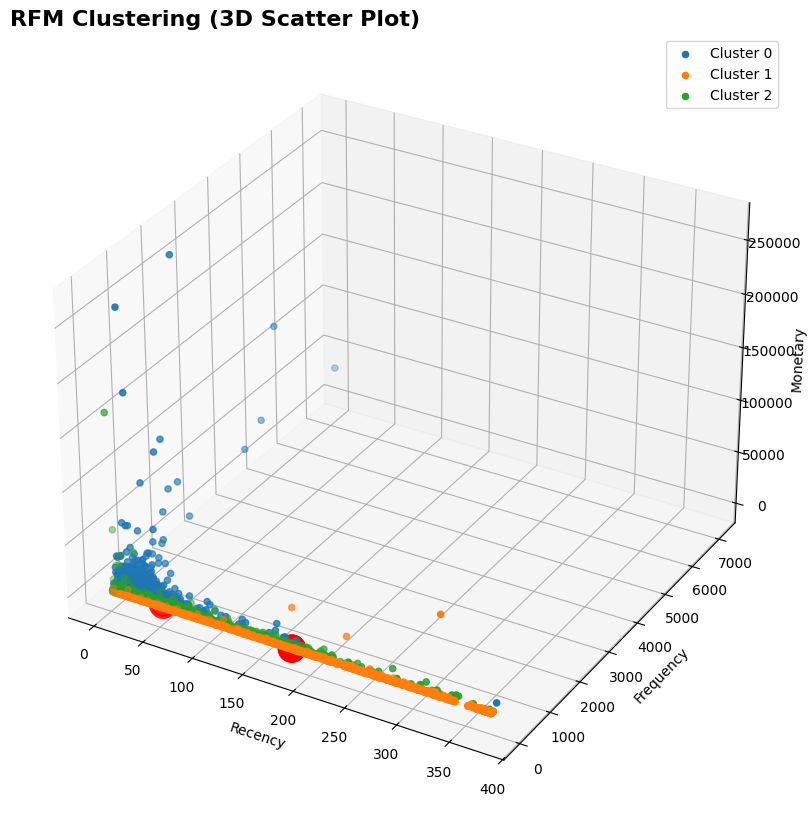

In [216]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')
k = 3

for i in range(k):
    cluster_data = rfm[rfm['Cluster'] == i]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'Cluster {i}')
    # Plot centroids
    centroids = rfm_clusters
    ax.scatter(centroids['Recency'], centroids['Frequency'], centroids['Monetary'], marker='o', s=300, linewidths=3, color='red', zorder=10)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Clustering (3D Scatter Plot)',loc = 'left',  fontweight = 'heavy', fontsize = 16)
ax.legend()
plt.show()


#### **2. Summary RFM after clustering and evaluating metrics**

In [217]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,1
1,12347.0,3,162,3653.45,0
2,12348.0,76,27,1437.24,2
3,12349.0,19,68,1372.42,2
4,12350.0,311,13,258.00,1
...,...,...,...,...,...
4310,18280.0,278,10,180.60,1
4311,18281.0,181,7,80.82,1
4312,18282.0,8,12,178.05,2
4313,18283.0,4,719,1964.26,0


`Đánh giá các cụm`

In [218]:
# Create number for each cluster dataframe
cluster_df = rfm['Cluster'].value_counts().to_frame().reset_index()
cluster_df.columns = ['Cluster', 'Number']
cluster_df

,Cluster,Number
0,2,1908
1,1,1571
2,0,836


In [223]:
import plotly.express as px

# Giả sử rfm_clusters là DataFrame của bạn
fig = px.scatter(rfm_clusters, x="Recency", y="Monetary", size="Frequency", color="Cluster", hover_name="Cluster", size_max=100)
fig.update_layout(height=500, width=1500)
fig.update_layout(
    title="Details for each Clusters with Mean RFM values",
    height=500,
    width=1500
)
fig.show()


Số lượng khách hàng trong mỗi cụm tương đối đồng đều, không có sự khác biệt đáng kể. Điều này cho thấy quá trình phân cụm có hiệu quả và các cụm có quy mô tương tự nhau.

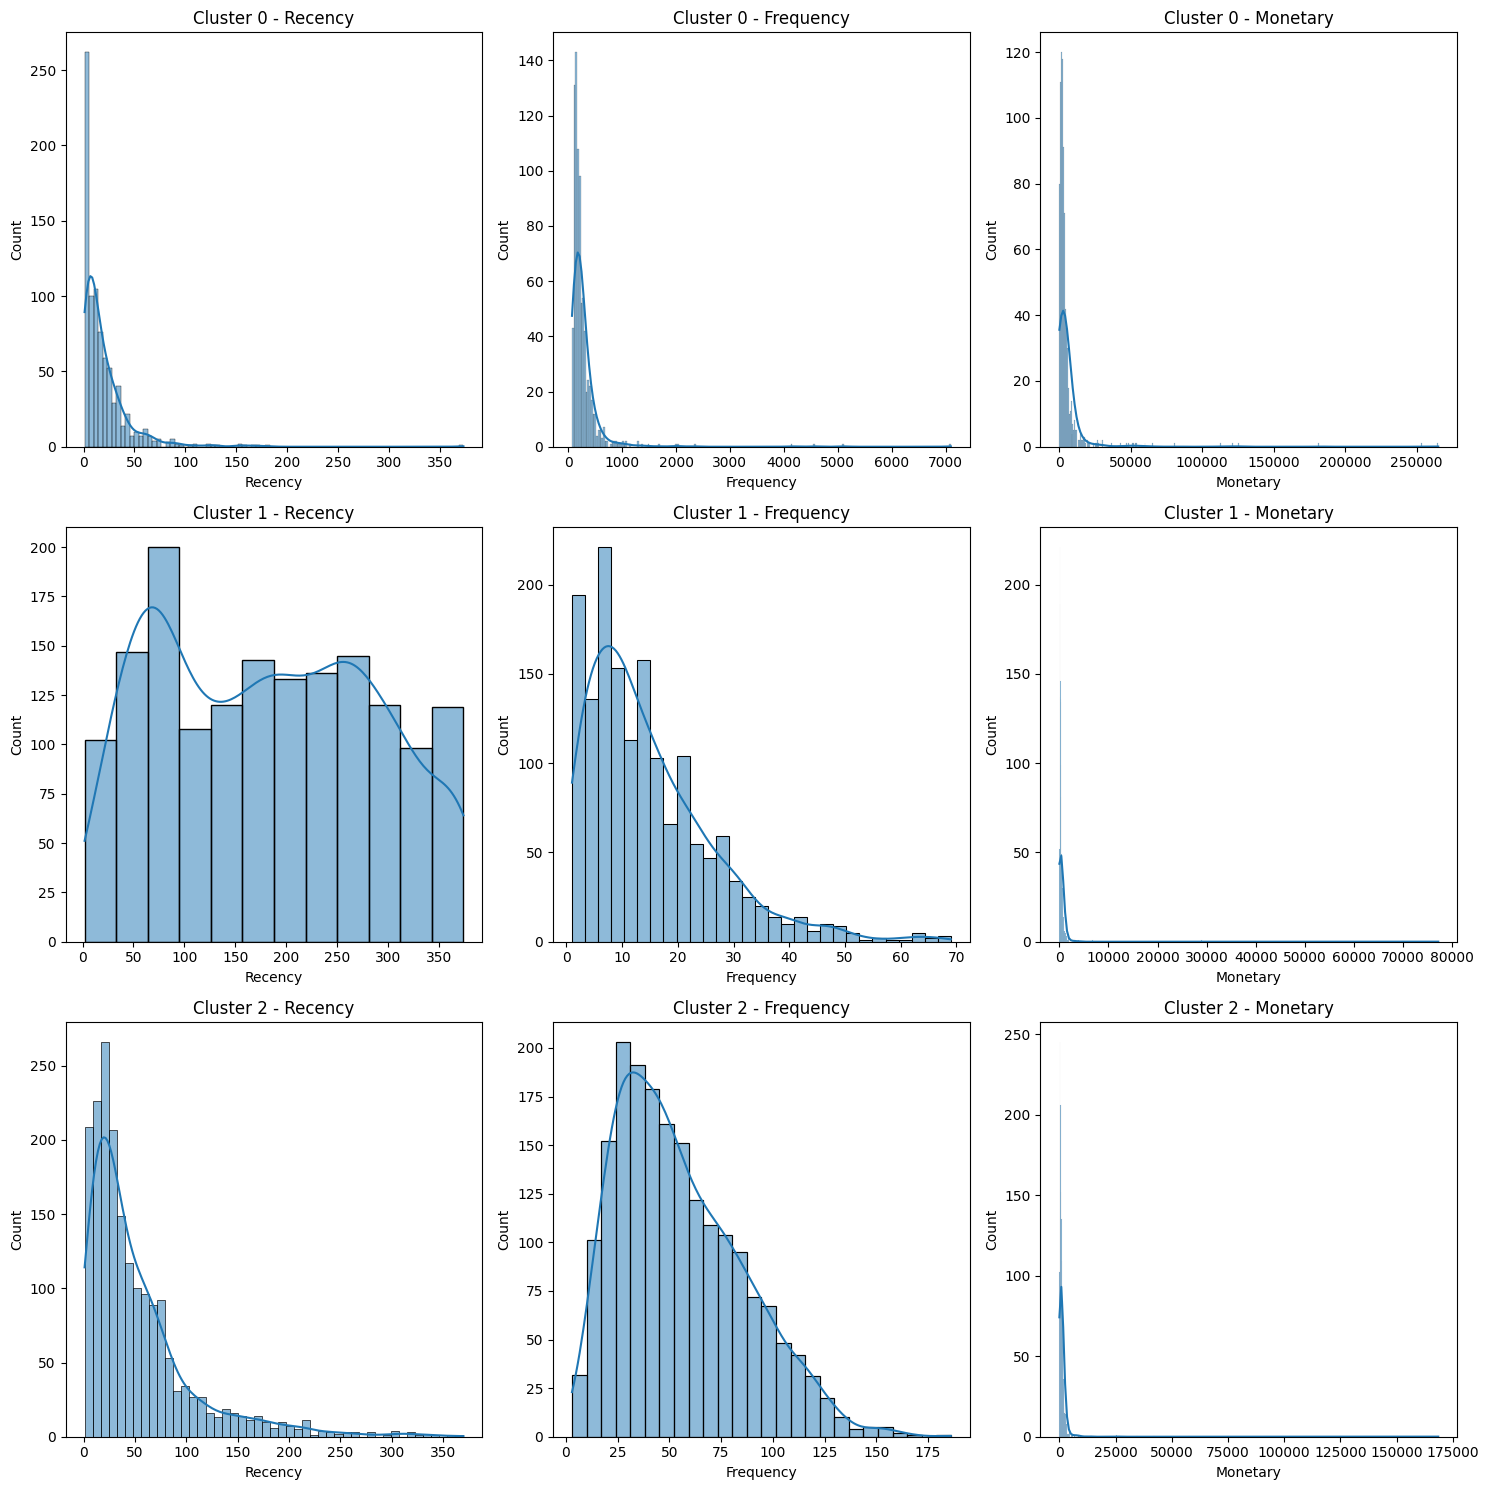

In [224]:
# vẽ hist
# Create subplots for each segment
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, segment in enumerate(['Cluster 0', 'Cluster 1', 'Cluster 2']):
    segment_data = rfm[rfm['Cluster'] == i]
    sb.histplot(segment_data['Recency'], ax=axes[i, 0], kde=True).set_title(f'{segment} - Recency')
    sb.histplot(segment_data['Frequency'], ax=axes[i, 1], kde=True).set_title(f'{segment} - Frequency')
    sb.histplot(segment_data['Monetary'], ax=axes[i, 2], kde=True).set_title(f'{segment} - Monetary')

plt.tight_layout()
plt.show()


Các cụm được phân ra khá rõ ràng

##  **IV. Evaluate and select customer types by Segment scores**

In [225]:
rfm_clusters

,Cluster,Recency,Frequency,Monetary
0,0,20.0,281.0,5854.0
1,1,182.0,15.0,454.0
2,2,52.0,55.0,1262.0


In [226]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Dữ liệu mẫu (thay thế bằng dữ liệu của bạn)
all_clusters = rfm.describe().applymap(lambda x: '{:.2f}'.format(x))
all_clusters['Cluster'] = 'All'

cluster_0 = rfm[rfm['Cluster'] == 0].describe().applymap(lambda x: '{:.2f}'.format(x))
cluster_0['Cluster'] = 'Cluster 0'

cluster_1 = rfm[rfm['Cluster'] == 1].describe().applymap(lambda x: '{:.2f}'.format(x))
cluster_1['Cluster'] = 'Cluster 1'

cluster_2 = rfm[rfm['Cluster'] == 2].describe().applymap(lambda x: '{:.2f}'.format(x))
cluster_2['Cluster'] = 'Cluster 2'

# Gộp các bảng lại
combined_table = pd.concat([all_clusters, cluster_0, cluster_1, cluster_2], axis=0).reset_index()

# Khởi tạo ứng dụng Dash
app = dash.Dash(__name__)

# Layout của ứng dụng
app.layout = html.Div([
    html.H1("RFM Heat Map with Cluster Filter", style={'textAlign': 'center', 'color': 'blue', 'fontWeight': 'bold'}),
    dcc.Dropdown(
        id='cluster-filter',
        options=[
            {'label': 'All', 'value': 'All'},
            {'label': 'Cluster 0', 'value': 'Cluster 0'},
            {'label': 'Cluster 1', 'value': 'Cluster 1'},
            {'label': 'Cluster 2', 'value': 'Cluster 2'}
        ],
        value='All',  # Mặc định hiển thị "All"
        placeholder="Select Cluster"
    ),
    dcc.Graph(id='heatmap')
])

# Callback để cập nhật Heat Map
@app.callback(
    Output('heatmap', 'figure'),
    [Input('cluster-filter', 'value')]
)
def update_heatmap(selected_cluster):
    # Lọc dữ liệu theo cụm được chọn
    filtered_data = combined_table[combined_table['Cluster'] == selected_cluster] if selected_cluster != 'All' else combined_table
    # Loại bỏ cột không cần thiết
    heatmap_data = filtered_data.set_index('index').drop(columns=['Cluster'])
    
    # Tạo Heat Map
    fig = px.imshow(
        heatmap_data,
        text_auto=True,
        labels={'x': 'Metrics', 'y': 'Statistics', 'color': 'Value'},
        title=f"Heat Map for {selected_cluster if selected_cluster != 'All' else 'All Clusters'}",
        width=1100,  # Chiều ngang (pixels)
        height=500,   # Chiều dọc (pixels)
        aspect="auto"
    )
    return fig

# Chạy ứng dụng
if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18424\846592828.py:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18424\846592828.py:9: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18424\846592828.py:12: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18424\846592828.py:15: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



#### **Sau khi phân tích chart và segment scores lên thì ta đánh giá và phân loại khách hàng như sau**

#### **Segment 0**
`Đánh giá các chỉ số:`
- **Recency:** Thời gian mua hàng trung bình gần nhất là 20 ngày, và giao động chủ yếu từ 1 đến 25 ngày ▶ Rất ngắn ▶ Khách hàng mua hàng khá thường xuyên
- **Frequency:** Tần suất mua hàng trung bình 281 lần trên hơn 1 năm. Tần suất giao động từ 71 đến 293 lần trong hơn 1 năm ▶ Khách hàng rất thường xuyên mua hàng ▶ Tần suất mua hàng ở mức rất tốt
- **Monetary:** Giá trị giao dịch trung bình 5854.  Mức chi tiêu giao động từ 1669 - 4755 ▶ Rất cao ▶ Mua hàng với tổng giá trị rất cao

`Kết luận:`
Segment 0 có thể được phân loại vào nhóm "Khách hàng VIP" (VIP Customers) hoặc "Champions" : Là những khách hàng mới giao dịch, mua hàng thường xuyên và chi tiêu nhiều nhất.Những khách hàng này rất trung thành, sẵn sàng chi tiêu hào phóng và có khả năng sẽ sớm thực hiện một giao dịch mua khác.

`Để khai thác hết tiềm năng của nhóm khách hàng này, chúng ta cần:`
- Chăm sóc VIP: Cung cấp dịch vụ khách hàng ưu tiên, chương trình khách hàng VIP, quà tặng đặc biệt, ưu đãi độc quyền, và các chương trình tri ân dành riêng cho họ.
- Thấu hiểu sâu sắc: Phân tích chi tiết hơn về lịch sử mua hàng, sản phẩm ưa thích, hành vi mua hàng, để hiểu rõ nhu cầu và sở thích của họ.
- Tăng cường tương tác: Tạo các chương trình tương tác, khuyến khích họ chia sẻ ý tưởng, phản hồi để xây dựng mối quan hệ lâu dài.
- Phát triển sản phẩm: Phát triển các sản phẩm mới hoặc các dịch vụ nâng cao phù hợp với nhu cầu của họ.
- Kiểm tra các bất thường: Cần kiểm tra xem có bất kỳ bất thường nào trong dữ liệu của nhóm này, chẳng hạn như lỗi ghi nhận, mua hàng bất thường, để đảm bảo chính xác của phân tích.

#### **Segment 1**

`Đánh giá các chỉ số:`
- **Recency:** Thời gian mua hàng trung bình gần nhất là 182 ngày ▶ Khá lâu ▶ Khách hàng chưa quay lại mua hàng gần đây
- **Frequency:** Tần suất mua hàng trung bình 15 lần trên hơn 1  năm. Tần suất giao động từ 6 đến 20 lần ▶ Thấp ▶ Tần suất mua hàng ở mức yếu
- **Monetary:** Giá trị giao dịch trung bình 454. Mức chi tiêu giao động từ 137 - 409 ▶ Thấp ▶ Mua hàng với tổng giá trị rất thấp

`Kết luận:`
Segment 1 có thể được phân loại vào nhóm khách hàng "Khách hàng gặp ngủ đông" (Hibernating Customers): Là những khách hàng đã khá lâu không quay lại, sức mua yếu (tần suất mua thấp và giá trị giỏ hàng không cao).

`Để khai thác hết tiềm năng của nhóm khách hàng này, chúng ta cần:`
- Kích hoạt lại: Cần có các chiến lược kích hoạt lại khách hàng, thu hút sự chú ý của họ và khuyến khích họ mua hàng trở lại. Ví dụ:
  - Cung cấp mã giảm giá hấp dẫn hoặc ưu đãi đặc biệt.
  - Gửi email hoặc tin nhắn nhắc nhở về sản phẩm mới hoặc chương trình khuyến mãi phù hợp với sở thích của họ.
  - Chia sẻ nội dung hấp dẫn về sản phẩm hoặc dịch vụ của bạn trên mạng xã hội.
- Cân nhắc loại bỏ: Nếu các chiến lược kích hoạt lại không hiệu quả, có thể cân nhắc loại bỏ họ khỏi danh sách tiếp thị.

`Để khai thác hết tiềm năng của nhóm khách hàng này, chúng ta cần:`
- Nâng cao trải nghiệm: Nâng cao trải nghiệm mua hàng cho khách hàng trung thành bằng các chương trình ưu đãi đặc biệt, dịch vụ khách hàng ưu tiên, quà tặng sinh nhật hoặc các ưu đãi độc quyền.
- Khuyến khích mua hàng: Tập trung vào việc cung cấp sản phẩm mới, khuyến mãi hấp dẫn phù hợp với sở thích của họ.
- Củng cố lòng trung thành: Tạo các chương trình khách hàng thân thiết, tích điểm, hoặc các chương trình tặng quà để khuyến khích họ tiếp tục mua hàng.
- Thấu hiểu nhu cầu: Phân tích thêm dữ liệu về khách hàng này, chẳng hạn như lịch sử mua hàng, sản phẩm ưa thích, để hiểu rõ nhu cầu của họ và đưa ra các khuyến nghị phù hợp và cá nhân hóa hơn.

#### **Segment 2**

`Đánh giá các chỉ số:`
- **Recency:** Thời gian mua hàng trung bình gần nhất là 52 ngày, giao động từ 18-67 ngày ▶ Gần 2 tháng khách hàng chưa mua hàng ▶ Khá dài
- **Frequency:** Tần suất mua hàng trung bình 55 lần trên hơn năm. Tần suất giao động từ 31 đến 75 lần ▶ Trung bình 1 tuần khách hàng sẽ mua 1 lần ▶  Ở mức Khá 
- **Monetary:** Giá trị giao dịch trung bình 1262. Giá trị giao động từ 416 - 1333 ▶ Khách hàng không chi tiền đều mà có lúc chi số tiền thấp, có lúc chi rất cao ▶ Khá ổn

`Kết luận:`
Segment 2 có thể được phân loại vào nhóm "Khách hàng không thể bỏ lỡ" (Can’t Lose Them): Là những khách hàng đã rất lâu không quay lại và từng mua hàng thường xuyên, với giá trị giỏ hàng rất lớn. Doanh nghiệp có thể đánh mất những khách hàng này nếu không có hoạt động kích thích họ quay lại.

`Để khai thác hết tiềm năng của nhóm khách hàng này, chúng ta cần:`
- Cung cấp ưu đãi đặc biệt: Giảm giá độc quyền hoặc quà tặng cá nhân hóa, dử dụng lời mời hấp dẫn như voucher miễn phí vận chuyển hoặc giảm giá lớn, nhắc nhở họ về các sản phẩm họ từng yêu thích.
- Thấu hiểu sâu sắc: Phân tích chi tiết hơn lý do họ ngừng mua sắm gần đây và xem xét những thay đổi trong thói quen mua sắm.
- Phát triển sản phẩm: Phát triển các sản phẩm mới hoặc các dịch vụ nâng cao phù hợp với nhu cầu của họ.

# **V. Transform Cluster to Segment**

In [227]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,1
1,12347.0,3,162,3653.45,0
2,12348.0,76,27,1437.24,2
3,12349.0,19,68,1372.42,2
4,12350.0,311,13,258.00,1
...,...,...,...,...,...
4310,18280.0,278,10,180.60,1
4311,18281.0,181,7,80.82,1
4312,18282.0,8,12,178.05,2
4313,18283.0,4,719,1964.26,0


In [228]:
rfm['Cluster'].value_counts()

Cluster
2    1908
1    1571
0     836
Name: count, dtype: int64

In [229]:
print(rfm_clusters.columns)

Index(['Cluster', 'Recency', 'Frequency', 'Monetary'], dtype='object')


In [230]:
# rfm_clusters.reset_index(inplace = True)
# Transform from Cluster to Segment name
rfm['Cluster'] = rfm['Cluster'].replace(0, 'Hibernating Customers')
rfm_clusters['Cluster'] = rfm_clusters['Cluster'].replace(0, 'VIP Customers')

rfm['Cluster'] = rfm['Cluster'].replace(1, 'Loyal Customers')
rfm_clusters['Cluster'] = rfm_clusters['Cluster'].replace(1, 'Hibernating Customers')

rfm['Cluster'] = rfm['Cluster'].replace(2, 'VIP Customers')
rfm_clusters['Cluster'] = rfm_clusters['Cluster'].replace(2, 'Can’t Lose Them')

# rfm = rfm.reset_index()
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,Loyal Customers
1,12347.0,3,162,3653.45,Hibernating Customers
2,12348.0,76,27,1437.24,VIP Customers
3,12349.0,19,68,1372.42,VIP Customers
4,12350.0,311,13,258.00,Loyal Customers
...,...,...,...,...,...
4310,18280.0,278,10,180.60,Loyal Customers
4311,18281.0,181,7,80.82,Loyal Customers
4312,18282.0,8,12,178.05,VIP Customers
4313,18283.0,4,719,1964.26,Hibernating Customers


In [231]:
rfm_clusters

,Cluster,Recency,Frequency,Monetary
0,VIP Customers,20.0,281.0,5854.0
1,Hibernating Customers,182.0,15.0,454.0
2,Can’t Lose Them,52.0,55.0,1262.0


In [232]:
# Merge Segment column from rfm dataframe in data df
cleaned_data = cleaned_data.merge(rfm[['CustomerID', 'Cluster']], on = 'CustomerID')

# Test sample data in dataframe
cleaned_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPay,Cluster
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,Hibernating Customers
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850.0,United Kingdom,15.30,Hibernating Customers
2,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01,4.25,17850.0,United Kingdom,25.50,Hibernating Customers
3,536366,22633,HAND WARMER UNION JACK,6,2010-12-01,1.85,17850.0,United Kingdom,11.10,Hibernating Customers
4,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01,1.85,17850.0,United Kingdom,11.10,Hibernating Customers
...,...,...,...,...,...,...,...,...,...,...
363114,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,10.20,VIP Customers
363115,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,12.60,VIP Customers
363116,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,16.60,VIP Customers
363117,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,16.60,VIP Customers


In [248]:
id_by_cluster = cleaned_data.groupby('Cluster').agg({'CustomerID': 'nunique'}).reset_index()
id_by_cluster
# Plot the segments
fig = px.bar(id_by_cluster, x='Cluster', y='CustomerID', color='Cluster', labels='CustomerID', 
             title='Customer Segmentation theo số lượng khách hàng (unique)')
fig.show()

Ta thấy số lượng các khách hàng theo Cluster không phân loại quá nhiều, Loyal và VIP Customer cao chứng tỏ cửa hàng đang có các chiến lượt chăm sóc khách hàng tốt

In [234]:
# to file csv
cleaned_data.to_csv('Dataset/data_end.csv', index=False)